In [1]:
# Imports
import numpy as np, pandas as pd, SimpleITK as sitk, matplotlib.pyplot as plt, os
import tensorflow as tf, pydicom as dicom, cv2, matplotlib as mpl, nibabel as nib
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [2]:
# Getting dataframe linking series_id of segmented scans with respective patient_id
masks = [x[:-4] for x in os.listdir("/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations")]
masks_img = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
masks_img['series_id'] = masks_img['series_id'].astype(str)
masks_red = masks_img[masks_img['series_id'].isin(masks)]
display(masks_red) # there are in total 206 segmented images

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
21,10217,16066,208.00,0
22,10228,30522,145.00,0
23,10228,40471,291.00,0
...,...,...,...,...
4453,65504,55928,144.00,0
4545,7642,778,183.00,0
4623,8848,41663,238.00,0
4624,8848,7384,367.00,0


Segmented scans in the nifti format need to be rotated by 90 degrees.
Scans in the dicom format first need to be ordered by file number(In case of the 1004 patient, 21057 series, that would mean from 171,172,173,....,1190,1191,1192. Than the order must be inverted
PS: ideally order it from highest to lowest but I already implemented it the other way and probably wont have time to reimplement it

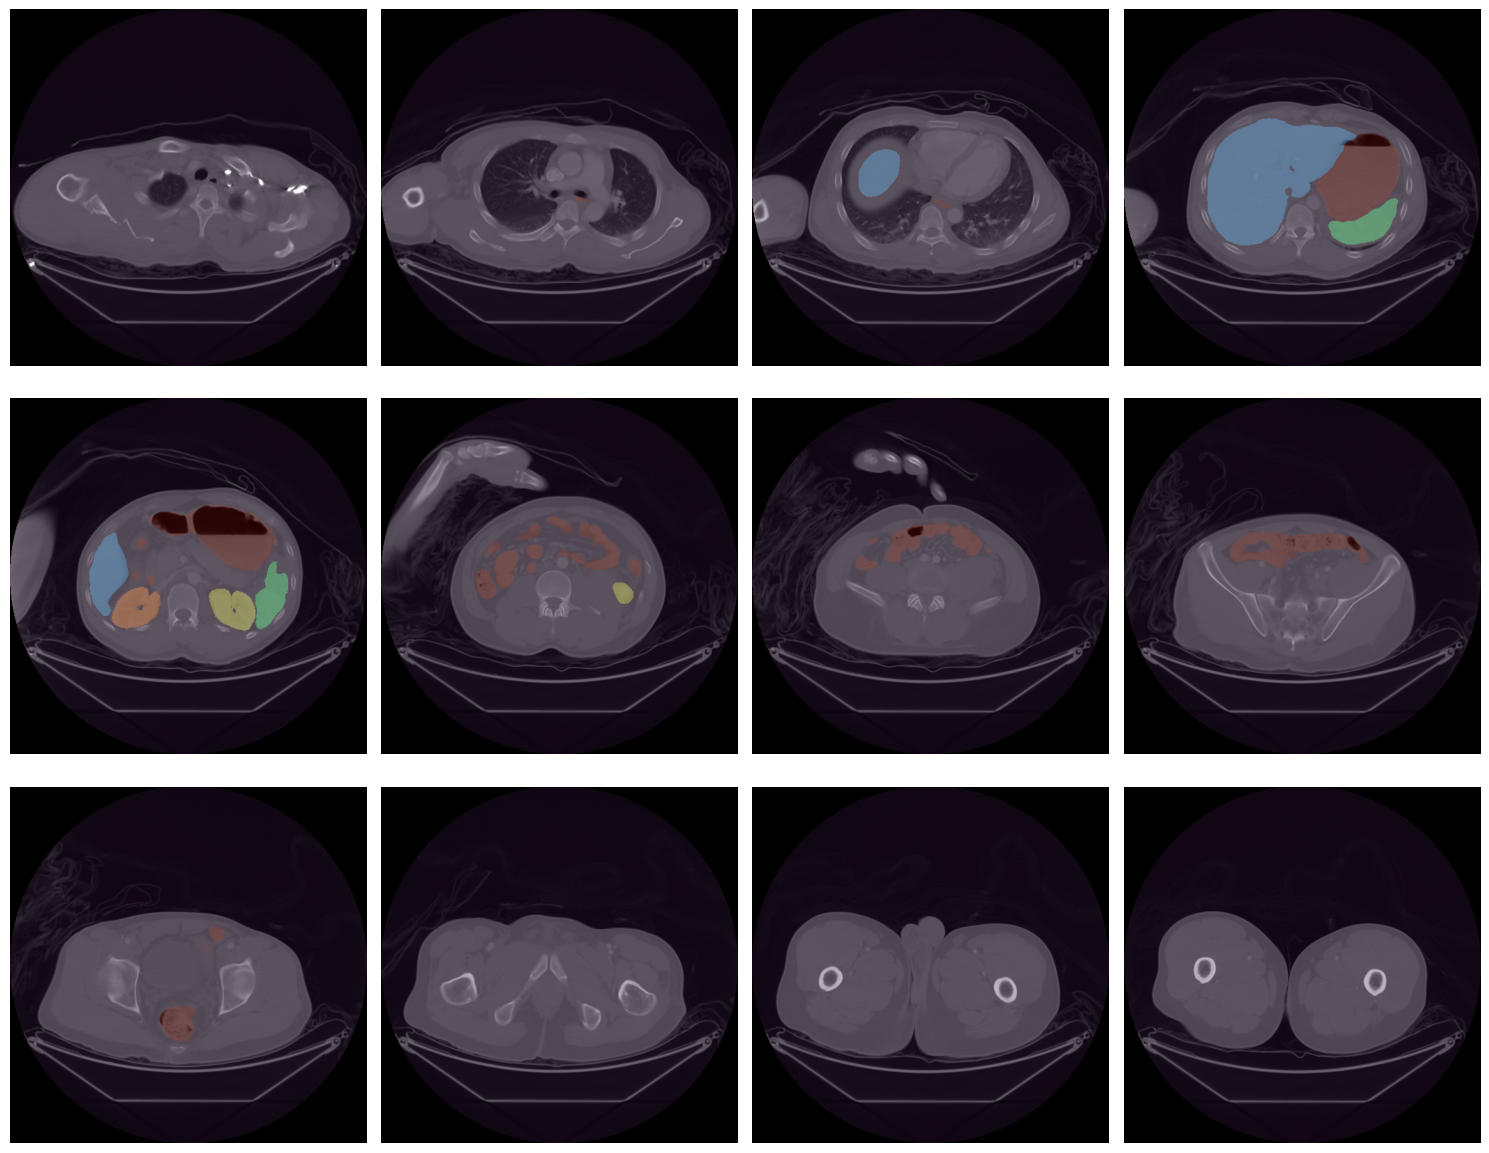

In [3]:
def display_scan_with_mask(number):
    # plotting stuff
    image_shape = (512,512)
    num_images = 12
    images = [np.random.rand(*image_shape) for _ in range(num_images)]
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    #reading list of dicoms for respective patient_id and ordering them
    patient_id = str(masks_red.iloc[number][0])
    series_id = str(masks_red.iloc[number][1])
    img_data = nib.load('/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/'+series_id+'.nii').get_fdata()
    dicoms = [int(x[:-4]) for x in os.listdir('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/'+patient_id+'/'+series_id)]
    dicoms = [str(x)+'.dcm' for x in sorted(dicoms)]
    
    for i, img in enumerate(range(0,len(dicoms),int((len(dicoms)/(num_images-1))))):
        alpha = 0.7
        ds = dicom.dcmread('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/'+patient_id+'/'+series_id+'/'+dicoms[img])
        rgb_ds = np.stack((ds.pixel_array,) * 3, axis=-1)/2542
        mask = mpl.colormaps['turbo'](img_data[:, :, -img] /5)[:, :, :3]
        combined = cv2.addWeighted(rgb_ds, alpha, np.rot90(mask), 1 - alpha, 0)
        axes[i].imshow(combined)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_scan_with_mask(205) # enter any number up to 205